# Compute uplift using expected power analysis

Expected power analysis computes the uplift with uncertainty bounds.  The method is an implementation of that described in [AWC validation methodology](https://publications.tno.nl/publication/34637216/LWOb3s/TNO-2020-R11300.pdf)

In [ ]:
from pathlib import Path

import pandas as pd

from flasc.analysis.analysis_input import AnalysisInput
from flasc.analysis.expected_power_analysis import (
    total_uplift_expected_power,
)
from flasc.analysis.expected_power_analysis_by import (
    total_uplift_expected_power_by_wd,
)

# Load processed data

In [2]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.pkl"
    df_scada = pd.read_pickle(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada


df_scada = load_data()

# Prepare data for processing

In [3]:
# Assign wd, ws and pow ref
# Subset dataframe
df_scada = df_scada.assign(
    wd=lambda df_: df_["wd_smarteole"],
    ws=lambda df_: df_["ws_smarteole"],
)

In [4]:
# For now limit down a bit
df_scada = df_scada[df_scada.wd.between(195, 240)]
df_scada = df_scada[df_scada.ws.between(4, 13)]
# df_scada

In [5]:
# Split df_scada into baseline and wake steeering on "controlled"
# periods
df_base = df_scada[df_scada.control_mode == "baseline"]
df_con = df_scada[df_scada.control_mode == "controlled"]

In [6]:
# Construct energy ratio input object using default 10 blocks
# TO DO: allow color specification in AnalysisInput
a_in = AnalysisInput([df_base, df_con], ["Baseline", "Controlled"])
er_colors = {"Baseline": "black", "Controlled": "red"}

## Uplift by wd

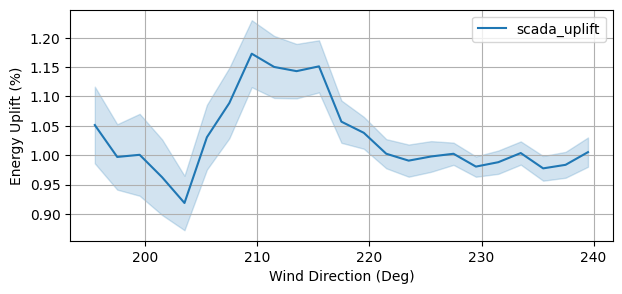

In [ ]:
t_wd = total_uplift_expected_power_by_wd(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=0.5,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)
t_wd.plot()

## Compute total uplift

In [ ]:
epao_standard_zero = total_uplift_expected_power(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4, 5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=0.5,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)

In [23]:
epao_standard_zero.uplift_results["scada_uplift"]

{'energy_uplift_ctr': 1.000690162322698,
 'energy_uplift_var': 4.579294432071609e-06,
 'energy_uplift_lb': 0.9964959793285219,
 'energy_uplift_ub': 1.0048843453168743,
 'df': shape: (221, 12)
 ┌────────┬────────┬─────────────┬────────────┬───┬──────────┬────────────┬────────────┬────────────┐
 │ wd_bin ┆ ws_bin ┆ weighted_fa ┆ weighted_f ┆ … ┆ weight   ┆ expected_p ┆ expected_p ┆ weighted_e │
 │ ---    ┆ ---    ┆ rm_power_Ba ┆ arm_power_ ┆   ┆ ---      ┆ ower_ratio ┆ ower_ratio ┆ xpected_po │
 │ f32    ┆ f32    ┆ seline      ┆ Controlled ┆   ┆ f64      ┆ ---        ┆ _var       ┆ wer_ratio_ │
 │        ┆        ┆ ---         ┆ ---        ┆   ┆          ┆ f32        ┆ ---        ┆ …          │
 │        ┆        ┆ f64         ┆ f64        ┆   ┆          ┆            ┆ f64        ┆ ---        │
 │        ┆        ┆             ┆            ┆   ┆          ┆            ┆            ┆ f64        │
 ╞════════╪════════╪═════════════╪════════════╪═══╪══════════╪════════════╪════════════╪══════